In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *

In [2]:
path = Path('../../data/results/exp2/sphere')
experiment=2
func='sphere'

In [3]:
D = 30
frequency = 100_000
max_times = 100
total_generations = max_times * frequency + 1000

In [4]:

if func=='sphere':
    if experiment==1 | experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return (indiv.data**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return ((indiv.data + 0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return ((indiv.data-b[t]*np.sin(np.pi/2*t))**2).sum()
        def constraint_func(indiv, b, t): return 0
    
elif func=='rastrigin':
    if experiment==1 | experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return 10*D+((indiv.data**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data+0.1*t)**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data-b[t]*np.sin(np.pi/2*t))**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

elif func=='rosenbrock':
    if experiment==1 | experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return ((100 * (indiv.data[1:] - indiv.data[:-1]**2)**2) + (1-indiv.data[:-1])**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return (100 * (((indiv.data[1:]+0.1*t) - (indiv.data[:-1]+0.1*t)**2)**2) + (1-indiv.data[:-1]-0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return (((100 * ((indiv.data[1:]-b[t]*np.sin(np.pi/2*t)) - (indiv.data[:-1]-b[t]*np.sin(np.pi/2*t))**2)**2) + (1-indiv.data[:-1]+b[t]*np.sin(np.pi/2*t))**2)).sum()
        def constraint_func(indiv, b, t): return 0

In [5]:
population = Population.new_random(dimension=D)

opt = Optimization(population, fitness_func, constraint_func, fitness_params=ab, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[OnChangeRestartPopulation])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 37:41


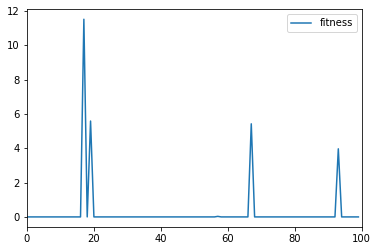

In [6]:
opt.run(total_generations, update_each=1)

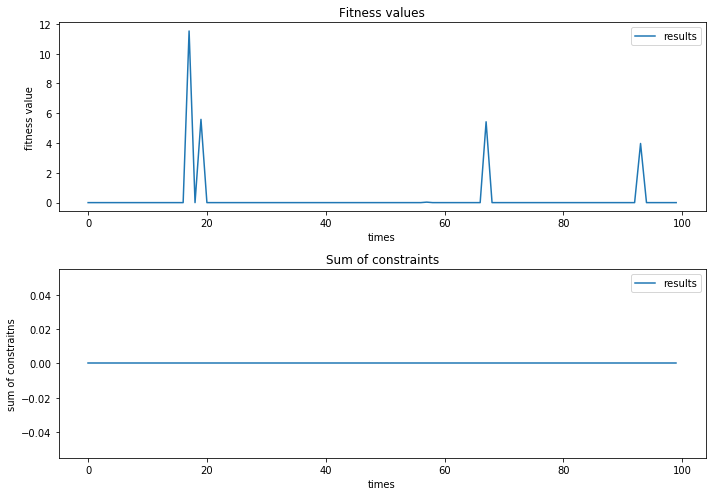

In [7]:
opt.recorder.plot();

In [8]:
df = pd.DataFrame({'fitness':opt.recorder.best_times_fitness, 'sum_constraints':opt.recorder.best_times_constraints})
df.head()

,fitness,sum_constraints
0,2.914832e-76,0
1,0.000000e+00,0
2,0.000000e+00,0
3,0.000000e+00,0
4,0.000000e+00,0


In [9]:
path.mkdir(parents=True, exist_ok=True)
df.to_csv(path/'best_known.csv', index=False)